In [30]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


In [31]:
titanic_data = pd.read_csv('train.csv')
titanic_data.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


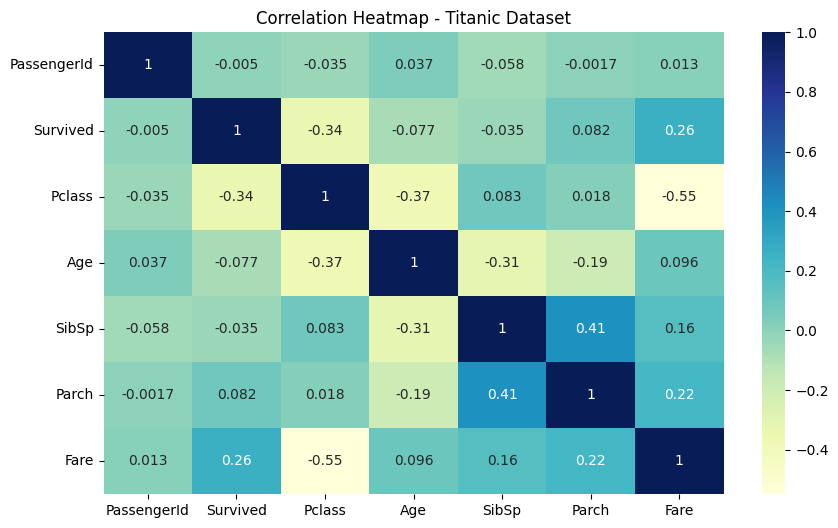

In [32]:
import seaborn as sns


corr_matrix = titanic_data.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap - Titanic Dataset")
plt.show()

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indicies, test_indicies in split.split(titanic_data, titanic_data[["Survived","Pclass","Sex"]]):
    strat_train_set = titanic_data.loc[train_indicies]  
    strat_test_set = titanic_data.loc[test_indicies]



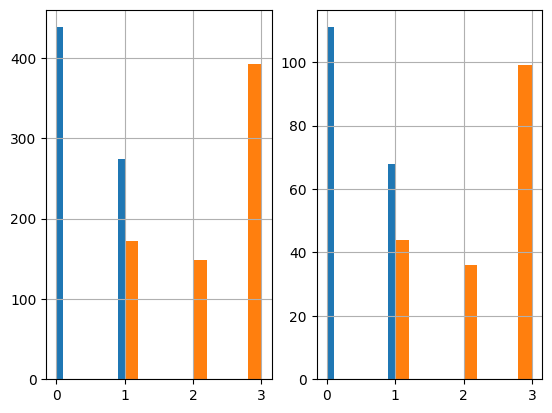

In [34]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.median_age = X["Age"].median()
        return self
    
    def transform(self, X):
        X = X.copy()
        X["Age"].fillna(self.median_age, inplace=True)
        return X

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Encode Sex
        X["Sex"] = X["Sex"].map({"male": 0, "female": 1})
        
        # Encode Embarked
        embark_mapping = {"C": 0, "Q": 1, "S": 2}
        X["Embarked"] = X["Embarked"].map(embark_mapping)
        
        return X


In [37]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=None):
        self.drop_cols = drop_cols if drop_cols is not None else ["Name", "Ticket", "Cabin"]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.drop_cols, errors="ignore")


In [38]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("ageimputer", AgeImputer()),
    ("featureencoder", FeatureEncoder()),
    ("featuredropper", FeatureDropper())
])

strat_train_set_transformed = pipeline.fit_transform(strat_train_set)



C:\Users\SURAT\AppData\Local\Temp\ipykernel_15532\4114202290.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Age"].fillna(self.median_age, inplace=True)


In [39]:
strat_train_set_transformed

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
585,586,1,1,1,18.0,0,2,79.6500,2
470,471,0,3,0,28.0,0,0,7.2500,2
319,320,1,1,1,40.0,1,1,134.5000,0
397,398,0,2,0,46.0,0,0,26.0000,2
330,331,1,3,1,28.0,2,0,23.2500,1
...,...,...,...,...,...,...,...,...,...
108,109,0,3,0,38.0,0,0,7.8958,2
293,294,0,3,1,24.0,0,0,8.8500,2
808,809,0,2,0,39.0,0,0,13.0000,2
343,344,0,2,0,25.0,0,0,13.0000,2


In [40]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set_transformed.drop(['Survived'], axis= 1)
Y = strat_train_set_transformed['Survived']


scaler = StandardScaler() 

X_data = scaler.fit_transform(X)
Y_data = Y.to_numpy()

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10,100,200,500], "max_depth": [None, 5 ,10], "min_samples_split":[2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv = 3, scoring="accuracy",return_train_score=True)
grid_search.fit(X_data,Y_data)


,estimator,RandomForestClassifier()
,param_grid,"[{'max_depth': [None, 5, ...], 'min_samples_split': [2, 3, ...], 'n_estimators': [10, 100, ...]}]"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,500


In [42]:
final_clf = grid_search.best_estimator_

In [43]:
strat_test_set = pipeline.transform(strat_test_set)

C:\Users\SURAT\AppData\Local\Temp\ipykernel_15532\4114202290.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Age"].fillna(self.median_age, inplace=True)
c:\Users\SURAT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [44]:
X_test = strat_test_set.drop(['Survived'], axis= 1)
Y_test =  strat_test_set['Survived']
scaler =StandardScaler()
X_data_test = scaler.fit_transform(X_test)
Y_data_test = Y_test.to_numpy()

In [45]:
final_clf.score(X_data_test,Y_data_test)


0.7932960893854749

In [46]:
final_data = pipeline.fit_transform(titanic_data)

C:\Users\SURAT\AppData\Local\Temp\ipykernel_15532\4114202290.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Age"].fillna(self.median_age, inplace=True)


In [47]:
X_final = final_data.drop(["Survived"],axis=1)
Y_final = final_data['Survived']
scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
Y_data_final = Y_final.to_numpy()

In [48]:
prod_clf = RandomForestClassifier()

param_gird = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(prod_clf, param_gird, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, Y_data_final)

,estimator,RandomForestClassifier()
,param_grid,"[{'max_depth': [None, 5, ...], 'min_samples_split': [2, 3, ...], 'n_estimators': [10, 100, ...]}]"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


In [49]:
prod_final_clf = grid_search.best_estimator_

In [50]:
prod_final_clf

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [51]:
titanic_test_data = pd.read_csv("test.csv")

In [52]:
final_test_data = pipeline.fit_transform(titanic_test_data)

C:\Users\SURAT\AppData\Local\Temp\ipykernel_15532\4114202290.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Age"].fillna(self.median_age, inplace=True)


In [53]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

C:\Users\SURAT\AppData\Local\Temp\ipykernel_15532\1896703401.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [54]:
predictions = prod_final_clf.predict(X_data_final_test)

In [56]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("predictions.csv", index=False)

In [57]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
